In [ ]:
# IMPORTANT NOTE: SET RUNTIME TO GPU IN COLAB BEFORE RUN

# Image classification vs Object detection

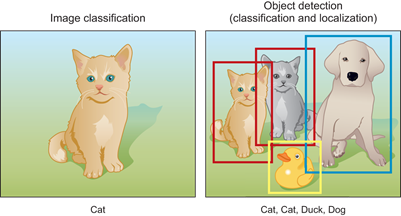

# Importing the Dataset and Libraries

In [17]:
import torch
from IPython.display import Image
import shutil
import os
from random import choice

# Cloning YoloV8 git Repo

In [3]:
!git clone https://github.com/ultralytics/ultralytics.git

fatal: destination path 'ultralytics' already exists and is not an empty directory.


In [4]:
# Installing YOLOV8 requirements files
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 636.3 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 kB 5.0 MB/s eta 0:00:0000:0100:01


## Preparing the COCO-text dataset for training and validation

**The Dataset YAML File**

The dataset YAML (data.yaml) file containing the path to the training and validation images and labels is already provided. This file will also contain the class names from the dataset.

The dataset is structured in the following manner:

```
dataset
├── images
│   ├── train
│   └── val
└── valid
    ├── train
    └── val

```

In [ ]:
import os
from random import choice
import shutil

In [ ]:
imgs =[]
xmls =[]

train_path = '/kaggle/working/dataset/images/train'
val_path = '/kaggle/working/dataset/images/val'
source_path = '/kaggle/input/cocotext-v20/data'

if not os.path.exists(train_path):
  os.makedirs(train_path)
if not os.path.exists(val_path):
  os.makedirs(val_path)

train_ratio = 0.8
val_ratio = 0.2

#total count of imgs
totalImgCount = len(os.listdir(source_path))/2

#soring files to corresponding arrays
for (dirname, dirs, files) in os.walk(source_path):
    for filename in files:
        if filename.endswith('.txt'):
            xmls.append(filename)
        else:
            imgs.append(filename)

#counting range for cycles
countForTrain = int(len(imgs)*train_ratio)
countForVal = int(len(imgs)*val_ratio)
print("training images are : ",countForTrain)
print("Validation images are : ",countForVal)

In [ ]:
import random

trainimagePath = '/kaggle/working/dataset/images/train'
trainlabelPath = '/kaggle/working/dataset/labels/train'
valimagePath =   '/kaggle/working/dataset/images/val'
vallabelPath =   '/kaggle/working/dataset/labels/val'

if not os.path.exists(trainimagePath):
  os.makedirs(trainimagePath)
if not os.path.exists(trainlabelPath):
  os.makedirs(trainlabelPath)
if not os.path.exists(valimagePath):
  os.makedirs(valimagePath)
if not os.path.exists(vallabelPath):
  os.makedirs(vallabelPath)

for x in range(countForTrain):
    fileJpg =  random.choice(imgs) # get name of random image from origin dir
    fileXml = fileJpg[:-4] +'.txt' # get name of corresponding annotation file

    #move both files into train dir
    shutil.copy(os.path.join(source_path, fileJpg), os.path.join(trainimagePath, fileJpg))
    shutil.copy(os.path.join(source_path, fileXml), os.path.join(trainlabelPath, fileXml))


    #remove files from arrays
    imgs.remove(fileJpg)
    xmls.remove(fileXml)

#cycle for test dir
for x in range(countForVal):
    fileJpg =  random.choice(imgs) # get name of random image from origin dir
    fileXml = fileJpg[:-4] +'.txt' # get name of corresponding annotation file

    #move both files into train dir

    shutil.copy(os.path.join(source_path, fileJpg), os.path.join(valimagePath, fileJpg))
    shutil.copy(os.path.join(source_path, fileXml), os.path.join(vallabelPath, fileXml))

    #remove files from arrays
    imgs.remove(fileJpg)
    xmls.remove(fileXml)

## Visualize a Few Ground Truth Images

Before moving forward, let's check out few of the ground truth images.

The current annotations in the text files are in normalized `[x_center, y_center, width, height]` format. Let's write a function that will Visualize a Few Ground Truth Images

In [30]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np
# from google.colab.patches import cv2_imshow

In [ ]:
import matplotlib.pyplot as plt 

In [28]:
def visualize_bounding_boxes(image_path, annotation_path):
    # Load the image
    image_BGR = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    with open(annotation_path) as f:
        lst = [line.rstrip() for line in f]

    # Going through all bounding boxes
    for i in range(len(lst)):
        # Getting current bounding box coordinates, width, and height
        bb_current = lst[i].split()
        x_center, y_center = int(float(bb_current[1]) * image_BGR.shape[1]), int(float(bb_current[2]) * image_BGR.shape[0])
        box_width, box_height = int(float(bb_current[3]) * image_BGR.shape[1]), int(float(bb_current[4]) * image_BGR.shape[0])

        # Calculate top-left corner coordinates (x_min, y_min)
        x_min = int(x_center - (box_width / 2))
        y_min = int(y_center - (box_height / 2))

        # Draw bounding box on the original image
        cv2.rectangle(image_BGR, (x_min, y_min), (x_min + box_width, y_min + box_height), [172, 10, 127], 2)

        # Prepare text with label and confidence for the current bounding box
        class_current = 'Class: {}'.format(bb_current[0])

        # Put text with label and confidence on the original image
        cv2.putText(image_BGR, class_current, (x_min, y_min - 5), cv2.FONT_HERSHEY_COMPLEX, 0.7, [172, 10, 127], 2)

    # Display the image with bounding boxes
#     cv2_imshow(image_BGR) 

    plt.imshow(image_BGR)

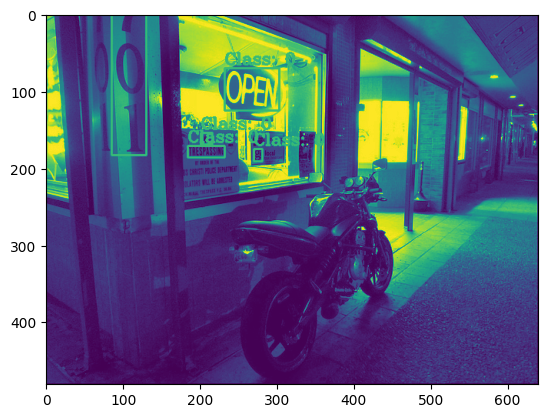

In [31]:
# Provide the image path, annotation path, and class names
image_path = '/kaggle/input/cocotext-v20/data/10.jpg'
annotation_path = '/kaggle/input/cocotext-v20/data/10.txt'
visualize_bounding_boxes(image_path, annotation_path)

## Train the model

In [10]:
from ultralytics import YOLO

In [8]:
!wandb disabled 
!yolo task=detect train data='/kaggle/input/dataset-yaml/dataset.yaml' model=yolov8n.pt epochs=40 

%load_ext tensorboard
%tensorboard --logdir runs

W&B disabled.
Ultralytics YOLOv8.2.29 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/input/dataset-yaml/dataset.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train31, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True

Reusing TensorBoard on port 6006 (pid 973), started 2:05:01 ago. (Use '!kill 973' to kill it.)

In [13]:
!yolo task=detect mode=val model='/kaggle/working/runs/detect/train31/weights/best.pt' data='/kaggle/input/dataset-yaml/dataset.yaml'

Ultralytics YOLOv8.2.29 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /kaggle/working/dataset/labels/val.cache... 3428 images, 0 backgro
val: WARNING ⚠️ /kaggle/working/dataset/images/val/9343.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       3428      16190      0.695      0.608      0.666      0.407
Speed: 0.2ms preprocess, 3.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val3
💡 Learn more at https://docs.ultralytics.com/modes/val


In [15]:
!yolo task=detect mode=predict model='/kaggle/working/runs/detect/train31/weights/best.pt' conf=0.25 source="/kaggle/working/dataset/images/val"

Ultralytics YOLOv8.2.29 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

image 1/3428 /kaggle/working/dataset/images/val/0.jpg: 448x640 1 Text, 66.6ms
image 2/3428 /kaggle/working/dataset/images/val/10.jpg: 512x640 8 Texts, 69.7ms
image 3/3428 /kaggle/working/dataset/images/val/10013.jpg: 480x640 9 Texts, 66.2ms
image 4/3428 /kaggle/working/dataset/images/val/10017.jpg: 480x640 4 Texts, 6.1ms
image 5/3428 /kaggle/working/dataset/images/val/10023.jpg: 448x640 6 Texts, 6.7ms
image 6/3428 /kaggle/working/dataset/images/val/10039.jpg: 448x640 (no detections), 6.5ms
image 7/3428 /kaggle/working/dataset/images/val/10040.jpg: 640x448 (no detections), 67.0ms
image 8/3428 /kaggle/working/dataset/images/val/10041.jpg: 480x640 (no detections), 7.7ms
image 9/3428 /kaggle/working/dataset/images/val/10049.jpg: 640x640 2 Texts, 7.9ms
image 10/3428 /kaggle/working/dataset/images/val/10054.jpg: 448x640 11 Texts, 7.3

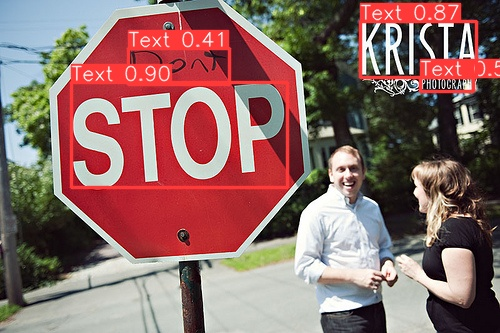

In [20]:
Image('runs/detect/predict/9999.jpg')

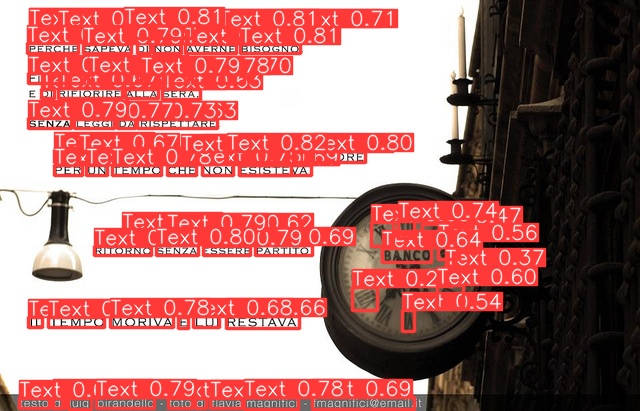

In [22]:
Image('runs/detect/predict/9892.jpg')

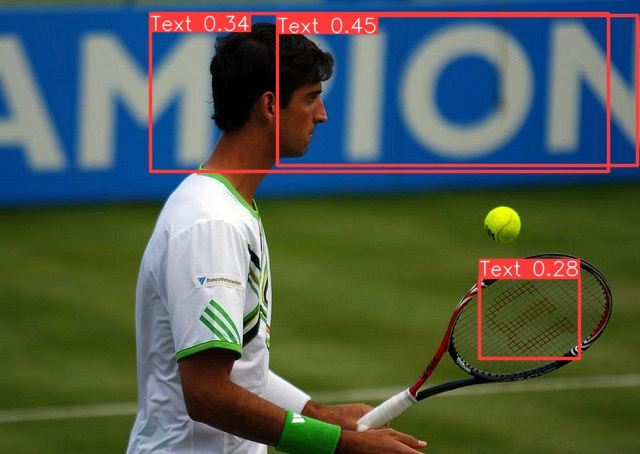

In [23]:
Image('runs/detect/predict/9876.jpg')

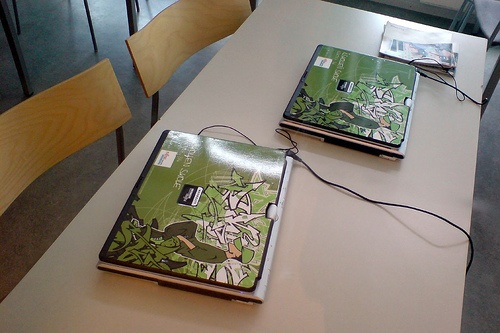

In [24]:
Image('runs/detect/predict/982.jpg')

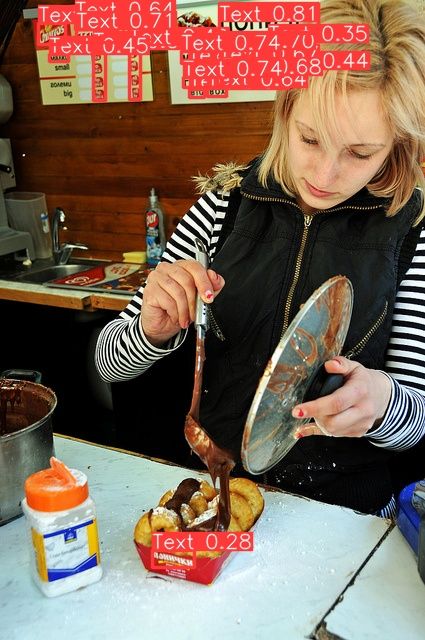

In [26]:
Image('runs/detect/predict/98.jpg')